In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import time

from python.analysis import cross_section, Plots

import numpy as np
import scipy.interpolate as interpolate

from IPython.display import clear_output
from pathos.multiprocessing import ProcessingPool
from rich import print

cross_section.SetPlotStyle(True, dpi = 140)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


For the toy simulation we need to generate:
 - $KE_{init}$ : initial kinetic energy
 - $KE_{int}$ : interacting kinetic energy
 - $z_{int}$ : 1D interacting vertex

The toy will simulate particles in an infinite volume of LAr, so there is no end of the detector or upstream loss to consider.

To generate $KE_{init}$ any PDF can be used, if we want to mimic the ProtoDUNE SP beam profile we can extract values from $KE^{true}_{init}$.
To genrate $KE_{int}$ and $z_{int}$, we can sample from a pdf which represents the probability of interacting with LAr. The probability of a particle interacting in a medium is related to the mean free path ($\lambda(E)$) of that material and it's path length distribution:

### $$ P_{int}(E, l) = \int^{l}_{0} p(E, l')dl' = \int^{l}_{0} \frac{1}{\lambda(E)} e^{-\frac{l'}{\lambda(E)}} dl' = 1 - e^{-\frac{l}{\lambda(E)}};\; \lambda(E) = \frac{M_{Ar}}{\sigma(E)N_{A}\rho} $$

### $$ \therefore P_{int}(E, l) = 1 - e^{-\sigma(E)\frac{N_{A}\rho l}{M_{Ar}}} $$

So for thin and energy slice measurements $l$ is the spatial slice thickness, but for the toy model, this is our sampling rate i.e. how often do we check if a particle has interacted. Particles loose energy as they travel through a medium, so whilst checking if the particle has interacted, we must compute the enegy lost by the particle as it travels a distance $l$, so use the bethe bloch formula for this:

### $$ E_{i + 1} = E_{i} - l \left< \frac{dE}{dX} \right>_{bb}(E_{i}) $$

The simulation procedure will be as follows (using rejection sampling to figure out if the particle interacted):
 1. Generate $KE_init$, set particle $KE_{int} = KE_{init}$ and distance travelled $dz_{int} = 0$
 2. Generate a random number from a uniform distribution U
 3. Find $P_{int}(KE_{int})$
 4. If $U < P_{int}(KE_{int})$ stop here, otherwise go to step 5
 5. Update $KE_{int}$ using the bethe bloch formula, update distsance travelled $z_{int} + l$, repeat from step 1.

if the particle Kinetic energy is zero, stop and assume it has decayed.

This is for one cross section $\sigma$ but a particle can interact in multiple distinguished ways, so rather than having one PDF for interactions we must sample from multiple to figure out which one occured. For a total inelastic cross section, we do the following (pcking up from step 4):

 5. For each cross section channel $j$ check $U < P^{j}_{int}(KE_{int})$, if this is true, stop otherwise try the next channel. If this is not true for all channels stop.

The PDFs themselves must also be created. From the Geant4 simulation we have plots which represent $\sigma(KE)$ but we do not have the exact formula, so an "emperical" formula is made by using interpolation. This constrains the toy from only being able to model cross sections for particles within the energy ranges defined by the Geant4 cross section plots.

# Generate PDF

In [2]:
def Generate_PDF(channel : str, l : float) -> np.array:
    """ Creates PDF for a given cross section channel and slice thickness (i.e. step size)

    Args:
        channel (str): _description_
        l (float): _description_

    Returns:
        np.array: _description_
    """
    xs_sim = cross_section.GeantCrossSections()
    P_int = 1 - np.exp(-1E-27 * getattr(xs_sim, channel) * 6.02214076e23 * cross_section.BetheBloch.rho * l / cross_section.BetheBloch.A)
    pdf = interpolate.interp1d(xs_sim.KE, P_int, fill_value = "extrapolate")
    return pdf

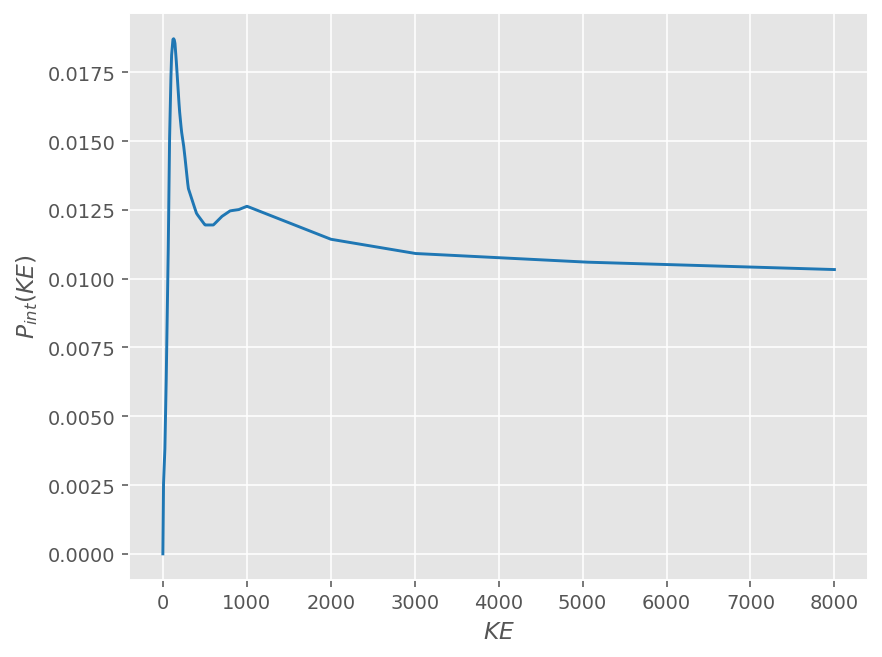

In [3]:
slice_thickness = 1
pdf = Generate_PDF("total_inelastic", slice_thickness)
Plots.Plot(np.linspace(0, 8000, 1000), pdf(np.linspace(0, 8000, 1000)), xlabel = "$KE$", ylabel = "$P_{int}(KE)$")

# Generate $KE_{init}$

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        4.0000e+00, 5.0000e+00, 1.4000e+01, 1.1000e+01, 1.4000e+01,
        2.7000e+01, 4.5000e+01, 6.0000e+01, 7.6000e+01, 9.2000e+01,
        1.3400e+02, 2.0300e+02, 2.4900e+02, 3.3700e+02, 4.8400e+02,
        6.3900e+02, 8.1800e+02, 9.8000e+02, 1.3460e+03, 1.6710e+03,
        2.1460e+03, 2.7710e+03, 3.4220e+03, 4.2020e+03, 5.2310e+03,
        6.1900e+03, 7.3980e+03, 8.6970e+03, 1.0406e+04, 1.2096e+04,
        1.3759e+04, 1.5785e+04, 1.7754e+04, 2.0036e+04, 2.2231e+04,
        2.4686e+04, 2.6528e+04, 2.8170e+04, 3.1037e+04, 3.2358e+04,
        3.4444e+04, 3.5730e+04, 3.6579e+04, 3.7537e+04, 3.8489e+04,
        3.8311e+04, 3.8063e+04, 3.7939e+04, 3.6537e+04, 3.5047e+04,
        3.4032e+04, 3.2168e+04, 3.0459e+04, 2.8506e+04, 2.6235e+04,
        2.4245e+04, 2.1563e+04, 1.9650e+04, 1.7147e+04, 1.5292e+04,
        1.3414e+04, 1.1415e+04, 9.9520e+03, 8.2270e+03, 7.0310e+03,
        5.9660e+03, 4.9870e+03, 3.9280e+03, 3.20

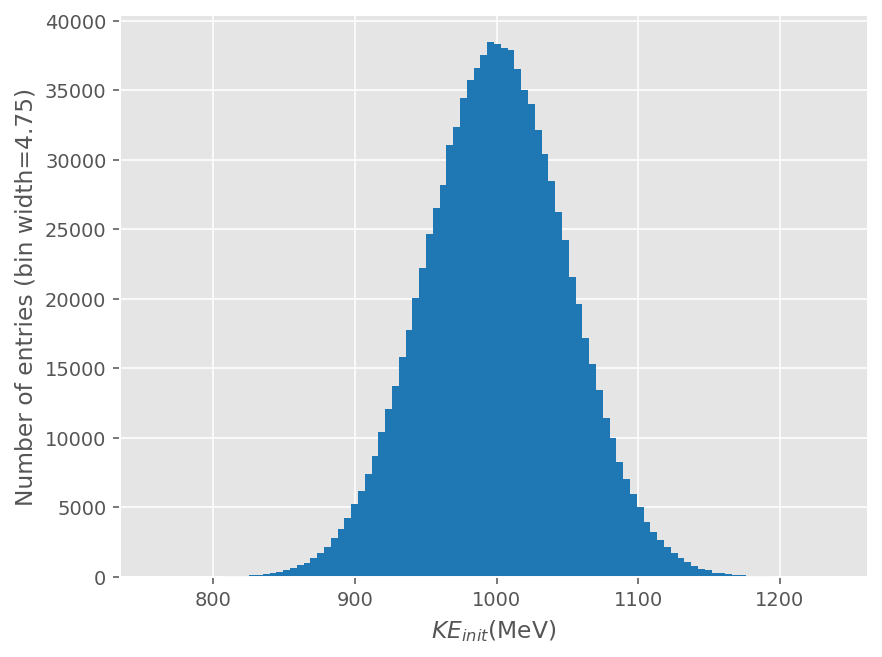

In [7]:
nEvents = int(1E6)
# KE_init = np.array([1000]*nEvents)
KE_init = np.random.normal(1000, 50, nEvents)

particle = cross_section.Particle.from_pdgid(211)

Plots.PlotHist(KE_init, xlabel = "$KE_{init}$(MeV)")

# Generate lifetimes ($t_{alive}$)

(array([1.27856e+05, 1.11468e+05, 9.70090e+04, 8.48550e+04, 7.37860e+04,
        6.44270e+04, 5.63040e+04, 4.89040e+04, 4.31310e+04, 3.73970e+04,
        3.24450e+04, 2.87400e+04, 2.48520e+04, 2.17430e+04, 1.89000e+04,
        1.62520e+04, 1.42650e+04, 1.25570e+04, 1.09900e+04, 9.52500e+03,
        8.19800e+03, 7.28200e+03, 6.40300e+03, 5.59700e+03, 4.84900e+03,
        4.18700e+03, 3.56800e+03, 3.13000e+03, 2.80400e+03, 2.34000e+03,
        2.15200e+03, 1.86700e+03, 1.54400e+03, 1.34100e+03, 1.19100e+03,
        1.02600e+03, 9.33000e+02, 8.19000e+02, 6.88000e+02, 6.16000e+02,
        5.54000e+02, 4.79000e+02, 4.08000e+02, 3.38000e+02, 2.71000e+02,
        2.75000e+02, 1.99000e+02, 2.09000e+02, 1.74000e+02, 1.41000e+02,
        1.40000e+02, 1.19000e+02, 9.20000e+01, 8.80000e+01, 6.80000e+01,
        7.10000e+01, 5.60000e+01, 4.50000e+01, 5.00000e+01, 3.20000e+01,
        3.00000e+01, 2.70000e+01, 1.70000e+01, 1.90000e+01, 1.50000e+01,
        1.40000e+01, 1.70000e+01, 1.50000e+01, 1.20

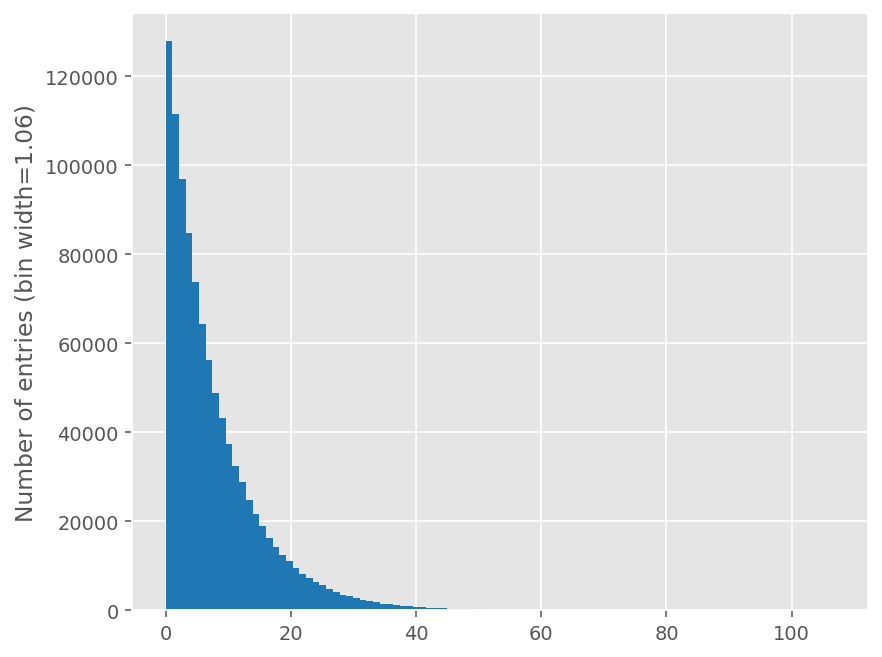

In [8]:
c = 299_792_458
t_alive = -np.log(np.random.random(nEvents)) * particle.lifetime * 1E-9 * c #m
Plots.PlotHist(t_alive)

# Generate $KE_{int}$ and $z_{int}$

In [24]:
def Beta(KE : np.array, mass : np.array):
    return (1 - (1/ (KE/mass)**2 ) )**0.5


def Simulate(KE_init : np.array, t_alive : np.array, stepsize, particle : cross_section.Particle, pdf : interpolate.interp1d, logging : bool = True) -> tuple[np.array, np.array]:
    survived = ~np.zeros(len(KE_init), dtype = bool)
    i = np.zeros(len(KE_init), dtype = int)
    t_travel = np.zeros(len(KE_init), dtype = float)
    KE_int = KE_init

    counter = 0
    while any(survived):
        t = time.time()
        U = np.random.uniform(0, 1, len(survived))

        survived = survived & (survived != (U < pdf(KE_int))) # interacts inelasticly do does not survive
        survived = survived & (survived != (KE_int < 1)) # has virtually no kinetic energy so decays
        # survived = survived & (survived != (t_travel >= t_alive)) # end of life so decays

        i = i + survived # distance travelled in step numbers
        # beta_start = Beta(KE_int, particle.mass)
        KE_int = KE_int - survived * stepsize * cross_section.BetheBloch.meandEdX(KE_int, particle)
        print(time.time() - t)
        # t_travel = survived * stepsize / (beta_start + Beta(KE_int, particle.mass)/2) #m

        if logging is True:
            if counter % 100 == 0:
                clear_output(True)
                print(counter)
                print(f"particles remaining: {sum(survived)}")

                if sum(survived) <= 10:
                    print(f"{KE_int[survived]=}")

                print(f"Progress: {100 * (1 - sum(survived)/len(survived)):.2f}")
        counter += 1
        if counter > 10: break

    z_int = i * stepsize
    if logging is True:
        clear_output(True)
        print(f"{counter=}")
        print(f"{KE_int=}")
        print(f"{survived=}")
        print(f"{i=}")
        print(f"{z_int=}")
    return KE_int, z_int

def SimulateMultiProcess(KE_init : np.array, t_alive : np.array, stepsize, particle : cross_section.Particle, pdf : interpolate.interp1d, nodes : int = os.cpu_count()):
    pool = ProcessingPool(nodes = nodes)
    KE_init_batches = np.array_split(KE_init, nodes)
    t_alive_batches = np.array_split(t_alive, nodes)
    args = [[slice_thickness]*nodes, [particle]*nodes, [pdf]*nodes, [False]*nodes]
    print(KE_init_batches)
    print(t_alive_batches)
    print(args)
    output = pool.map(Simulate, KE_init_batches, t_alive_batches, *args)
    return output

# print(SimulateMultiProcess(KE_init, t_alive, slice_thickness, particle, pdf))

KE_int, z_int = Simulate(KE_init, t_alive, slice_thickness, particle, pdf, logging = False)


0.31713080406188965

0.5104577541351318

0.47197818756103516

0.4400196075439453

0.4406406879425049

0.4466075897216797

0.4391179084777832

0.4306976795196533

0.43143320083618164

0.4313821792602539

0.45745420455932617

(array([6.1281e+04, 5.7470e+04, 5.4516e+04, 5.0852e+04, 4.7784e+04,
        4.4515e+04, 4.1834e+04, 3.9234e+04, 3.6936e+04, 3.4430e+04,
        3.2048e+04, 2.4271e+04, 2.9185e+04, 2.7250e+04, 2.5417e+04,
        2.4184e+04, 2.2339e+04, 2.0966e+04, 1.9464e+04, 1.8384e+04,
        1.7406e+04, 1.6225e+04, 1.2287e+04, 1.4609e+04, 1.3747e+04,
        1.2698e+04, 1.1936e+04, 1.1399e+04, 1.0630e+04, 9.9590e+03,
        9.3200e+03, 8.7390e+03, 8.1960e+03, 6.2220e+03, 7.2560e+03,
        7.0740e+03, 6.4690e+03, 6.0470e+03, 5.6080e+03, 5.1600e+03,
        5.1270e+03, 4.8420e+03, 4.4890e+03, 4.1760e+03, 3.0790e+03,
        3.6800e+03, 3.6990e+03, 3.4090e+03, 3.1970e+03, 3.0100e+03,
        2.8710e+03, 2.6090e+03, 2.5500e+03, 2.4300e+03, 2.3090e+03,
        1.7770e+03, 2.0760e+03, 1.9010e+03, 1.7010e+03, 1.6940e+03,
        1.6490e+03, 1.5520e+03, 1.3670e+03, 1.3970e+03, 1.2850e+03,
        1.2380e+03, 9.7200e+02, 1.0730e+03, 1.0540e+03, 1.0610e+03,
        1.0100e+03, 8.7900e+02, 8.4400e+02, 7.76

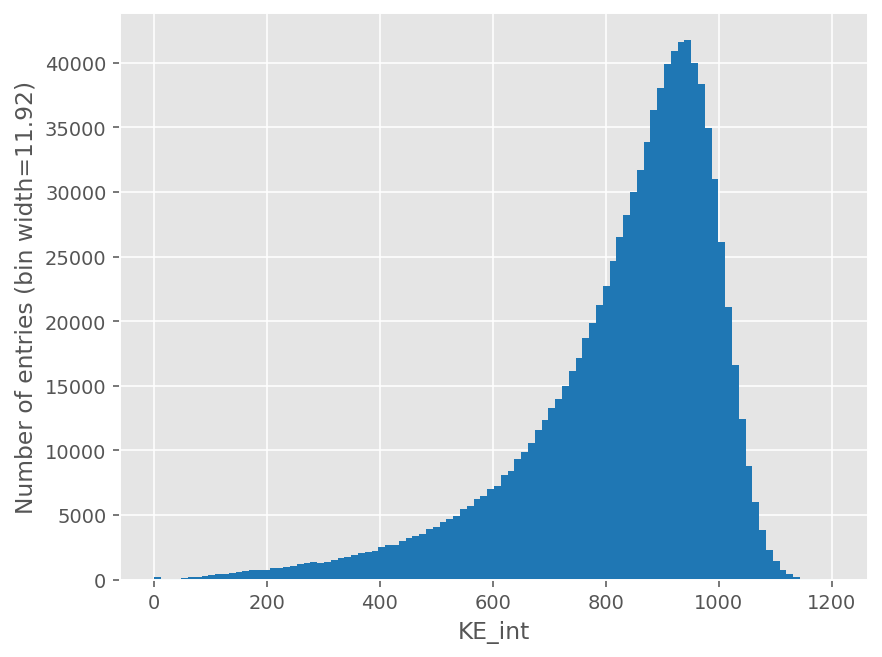

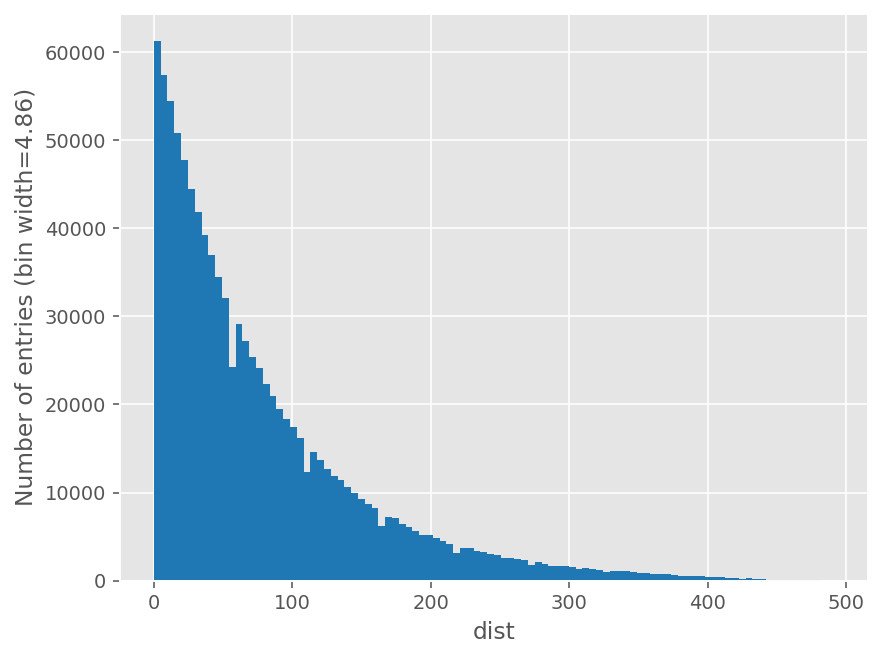

In [10]:
decayed = KE_int < 0
Plots.PlotHist(KE_int[~decayed], xlabel = "KE_int")
Plots.PlotHist(z_int[~decayed], xlabel = "dist")

# Thin slice method

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:530: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:532: RuntimeWarning: invalid value encountered in divide
  std_energy = np.divide(sum_energy_sqr, counts) - mean_energy**2


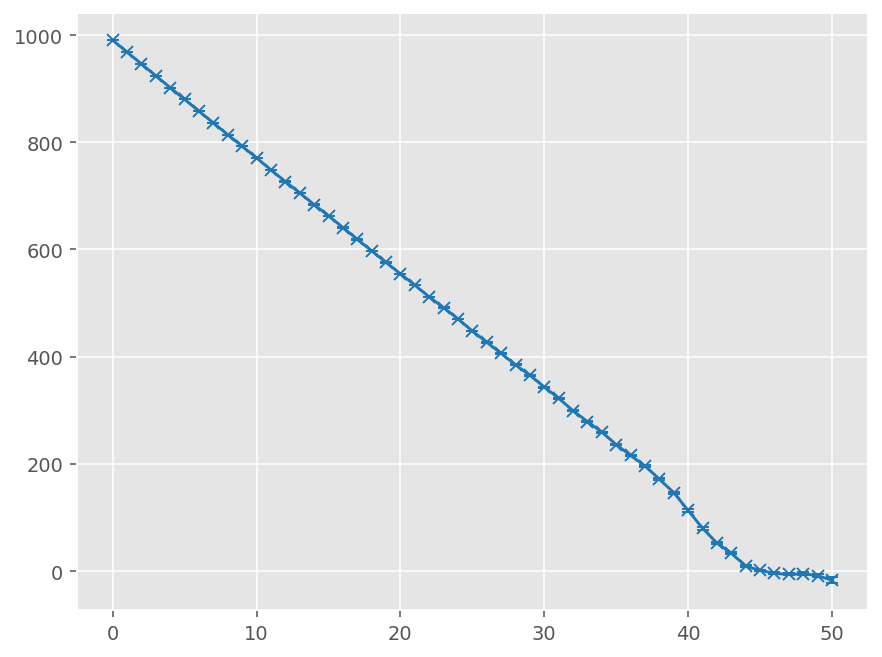

In [11]:
slices = cross_section.Slices(10, -10, 720)
mean_energy = cross_section.ThinSlice.MeanSliceEnergy(KE_int, z_int, slices)

Plots.Plot(slices.num[:-1], mean_energy[0], marker = "x", yerr = mean_energy[1])

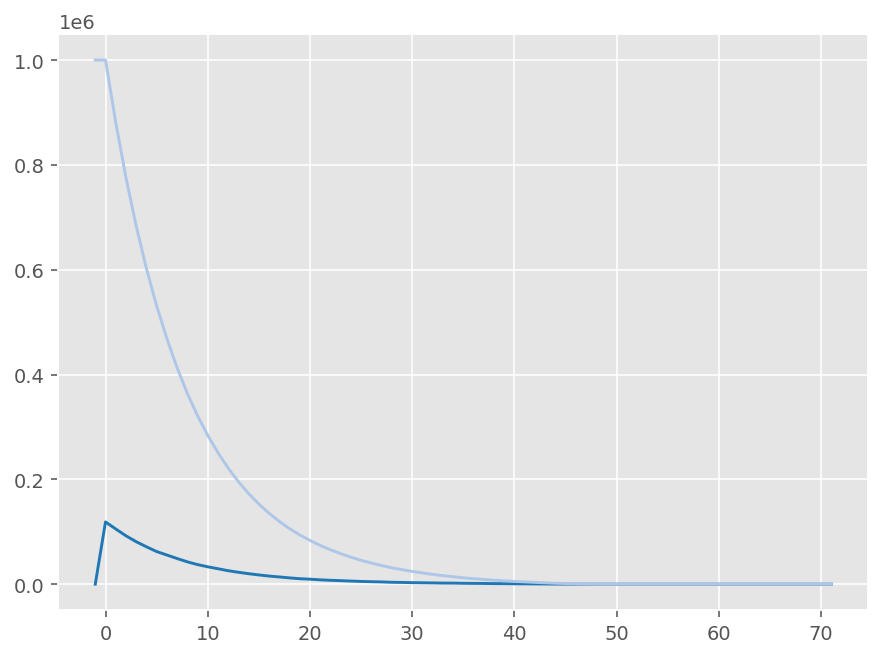

In [12]:
n_interact, n_incident = cross_section.ThinSlice.CountingExperiment(z_int, ~decayed, slices)

Plots.Plot(slices.num[:-1], n_interact)
Plots.Plot(slices.num[:-1], n_incident, newFigure = False)


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:550: RuntimeWarning: invalid value encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:553: RuntimeWarning: invalid value encountered in divide
  v_interact = n_interact*(1- (n_interact/n_incident)) # binomial uncertainty
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:555: RuntimeWarning: divide by zero encountered in divide
  xs_e = (1/n_incident) * (1/(n_incident - n_interact)) * (n_interact**2 * v_incident + n_incident**2 * v_interact)**0.5


(0.0, 2000.0)

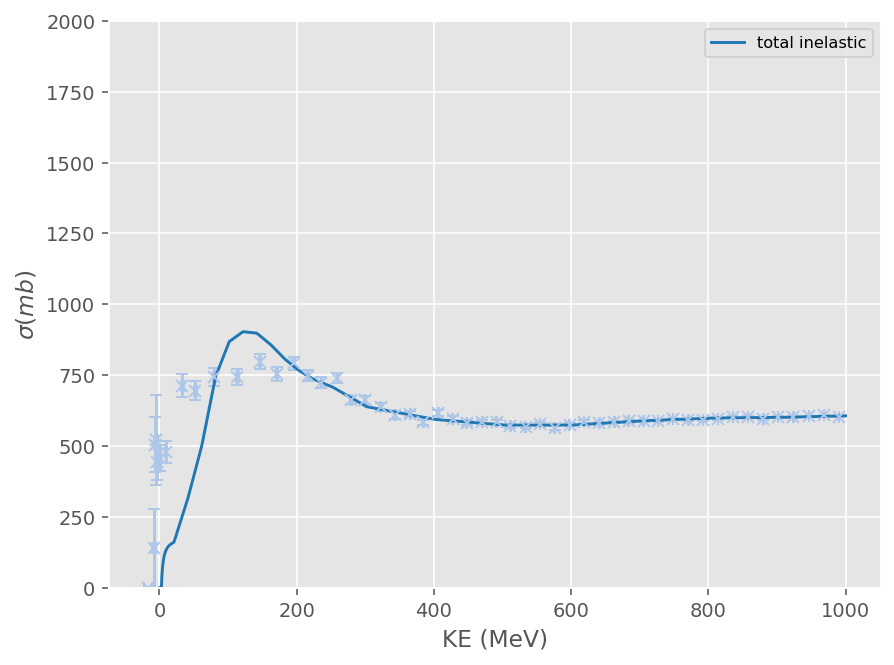

In [13]:
xs = cross_section.ThinSlice.CrossSection(n_incident, n_interact, slices.width)
geant_xs = cross_section.GeantCrossSections(energy_range = [0, 1000])

geant_xs.Plot("total_inelastic")
Plots.Plot(mean_energy[0], xs[0], xerr = mean_energy[1], yerr = xs[1], marker = "x", linestyle = "", newFigure = False)
Plots.plt.ylim(0, 2000)

# Encorperating particle decays

particles have essentially three options when passing through a thin target:
 1. interact with the material inelastically
 2. pass through (this includes elasitc sccatters)
 3. decay

if we treat elastic scatters as essentially no interaction, then just sampling from the inelastic PDF covers the first two cases, but not the third. In order to do the third, try the following:
 1. for each particle, compute a lifetime at the start of the simulation, this can be done with the typical exponential decay of particles and the particle lifetime in the pdg database
 2. keep track of each particles time as it passes through the TPC, note this muse be done for each particle separately as we allow distributions of kinetic energy. This is done at each thin target using the relation to $\beta$ and $KE$ derived below
 3. if the particles current time exceeds it's lifetime, classify it as decayed i.e. it did not survive.

Including this affect should lower the number of interactions at the low energy regime and thus elminate this issue of the cross section diverging. Note this means we need to also keep track of $\beta$ as the particle looses energy in each slice.

## Derivation of $\beta$
$$ KE = \sqrt{p^{2} + m^{2}} - m = \sqrt{(m\beta\gamma)^{2} + m^{2}} - m = \sqrt{\left(\frac{m\beta}{\sqrt{1 - \beta^{2}}}\right)^{2} + m^{2}} = \sqrt{\frac{m^{2}\beta^{2}}{1 - \beta^{2}} + m^{2}} = m\sqrt{\frac{\beta^{2}}{1 - \beta^{2}} + 1} $$

$$ \left(\frac{KE}{m}\right)^{2} - 1 = \frac{\beta^{2}}{1 - \beta^{2}} $$

$$ \beta^{2} = \left(\left(\frac{KE}{m}\right)^{2} - 1\right)\left(1 - \beta^{2}\right) = \left(\left(\frac{KE}{m}\right)^{2} - 1\right) - \left(\left(\frac{KE}{m}\right)^{2} - 1\right)\beta^{2} $$

$$ \left(\frac{KE}{m}\right)^{2} - 1 = \beta^{2} + \left(\left(\frac{KE}{m}\right)^{2} - 1\right)\beta^{2} = \left(\frac{KE}{m}\right)^{2}\beta^{2} $$

$$ \beta^{2} = \frac{\left(\frac{KE}{m}\right)^{2} - 1 }{ \left(\frac{KE}{m}\right)^{2} }$$

$$\therefore \beta = \sqrt{1 - \frac{1}{ \left(\frac{KE}{m}\right)^{2} }} $$


## Particle lifetime
$$ N(t) = N_{0} e^{-\frac{t}{\tau}} $$

$$ P_{decay} = e^{-\frac{t}{\tau}} $$

$$\ln\left( P_{decay} \right) = -\frac{t}{tau} $$

$$ t = -\tau\ln\left( P_{decay} \right) $$

So, sample from a random uniform distribution to get $P_{int}$

## Time elapsed at current slice
$$ t_{elapsed} = l \beta $$

In [157]:
tau = particle.lifetime*1E-9
n = 10000
decay_times = -np.log(np.random.random(n)) * tau

beta = (1 - (1/ (1000/particle.mass)**2 ) )**0.5
c = 299_792_458
print(f"{beta*c=} m/s")
print(f"{beta*c*tau=} m")

# t = np.zeros(n)
# n_survived = [n]
# decayed = np.zeros(n, dtype = bool)

# while sum(~decayed) > 0:
#     t += dt
#     decayed = np.random.random(len(t)) < (t/tau)
#     t = t[~decayed]
#     n_survived.append(sum(~decayed))

# Plots.Plot(np.linspace(0, dt * len(n_survived), len(n_survived)), n_survived)

# lifetime = []
# for i in range(n):
#     t = 0
#     decayed = False
#     while not decayed:
#         t += dt
#         if np.random.random() < t/tau:
#             decayed = True
#     lifetime.append(t)
# Plots.PlotHist(lifetime, bins = 50)

beta*c=296858135.02993375 m/s

beta*c*tau=7.7280325104749705 m

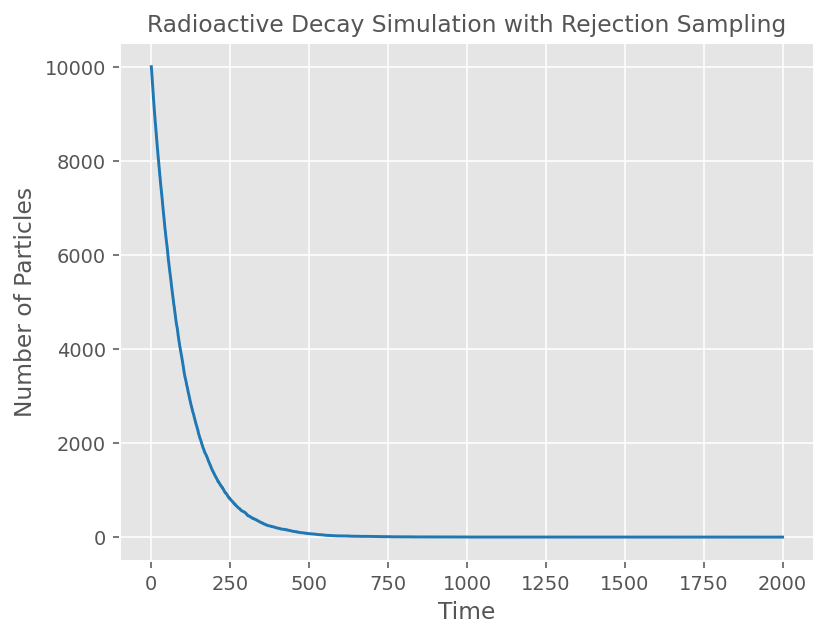

In [140]:
# code from ChatGPT
import numpy as np
import matplotlib.pyplot as plt

def radioactive_decay(N0, decay_constant, time):
    """
    Simulate radioactive decay using rejection sampling.

    Parameters:
        N0 (int): Initial number of radioactive particles.
        decay_constant (float): Decay constant (lambda) of the radioactive material.
        time (numpy array): Time points at which to simulate the decay.

    Returns:
        numpy array: Number of particles at each time point.
    """
    max_probability = np.exp(-decay_constant * time[-1])  # Maximum probability for rejection sampling
    num_particles = np.zeros_like(time)

    for i in range(N0):
        decay_time = -np.log(np.random.random()) / decay_constant  # Sample time from exponential distribution

        # Rejection sampling
        if decay_time <= time[-1]:
            index = np.searchsorted(time, decay_time)
            num_particles[index:] += 1

    return N0 - num_particles

# Simulation parameters
N0 = 10000    # Initial number of particles
decay_constant = 0.01  # Decay constant (lambda) - adjust this value to change decay rate
time = np.linspace(0, 2000, 1000000)  # Time points from 0 to 10 (adjust as needed)

# Simulate radioactive decay using rejection sampling
number_of_particles = radioactive_decay(N0, decay_constant, time)

# Plot the results
plt.plot(time, number_of_particles)
plt.xlabel('Time')
plt.ylabel('Number of Particles')
plt.title('Radioactive Decay Simulation with Rejection Sampling')
plt.grid(True)
plt.show()